# Load Data

### Small Test Example
* Load one sample each of interictal and preictal and split each into 10s windows.

In [1]:
def get_data_key_from_filename(filename):
    filename = filename.split("/")
    filename = filename[-1].split(".")
    filename = filename[0].split("_")
    filename = filename[2:]
    filename[-1] = filename[-1].lstrip("0")
    return "_".join(filename)

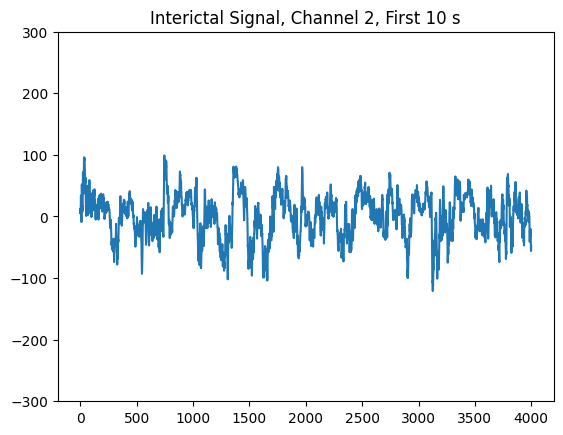

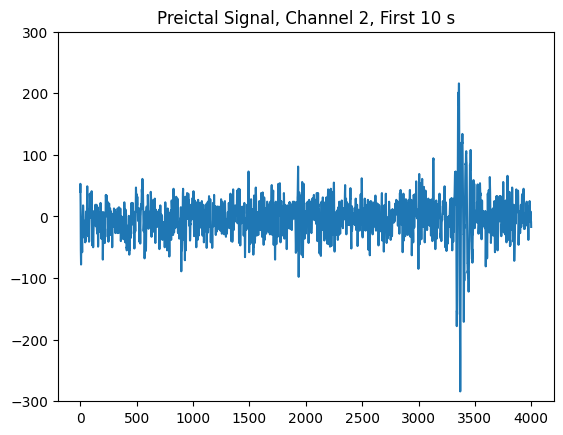

In [4]:
import matplotlib.pyplot as plt
# from feature_extraction import get_data_key_from_filename
import os
from scipy.io import loadmat
import numpy as np
from sklearn.preprocessing import MaxAbsScaler

root_folder = ""  #/Volumes/LACIE SHARE/seizure-prediction"
train_interictal_file = "Dog_1_interictal_segment_0009.mat"  #"Dog_1/Dog_1/Dog_1_interictal_segment_0009.mat"
train_preictal_file = "Dog_1_preictal_segment_0013.mat"  #"Dog_1/Dog_1/Dog_1_preictal_segment_0013.mat"

filepath = os.path.join(root_folder, train_interictal_file)
mat_data = loadmat(filepath)
signals_interictal = np.array(mat_data[get_data_key_from_filename(train_interictal_file)][0, 0][0])
signals_interictal = np.transpose(signals_interictal)   # convert so # timepoints x # channels
filepath = os.path.join(root_folder, train_preictal_file)
mat_data = loadmat(filepath)
signals_preictal = np.array(mat_data[get_data_key_from_filename(train_preictal_file)][0, 0][0])
signals_preictal = np.transpose(signals_preictal)   # convert so # timepoints x # channels

plt.plot(signals_interictal[0:4000, 1])
plt.title("Interictal Signal, Channel 2, First 10 s")
plt.ylim(-300, 300)
plt.show()
plt.plot(signals_preictal[0:4000, 1])
plt.title("Preictal Signal, Channel 2, First 10 s")
plt.ylim(-300, 300)
plt.show()

236000
0
(236000, 16)
(236000, 16)
Interictal Tensor Shape: (59, 4000, 16)
Preictal Tensor Shape: (59, 4000, 16)


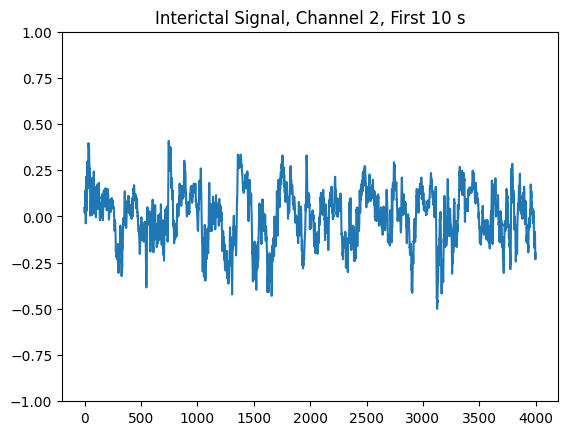

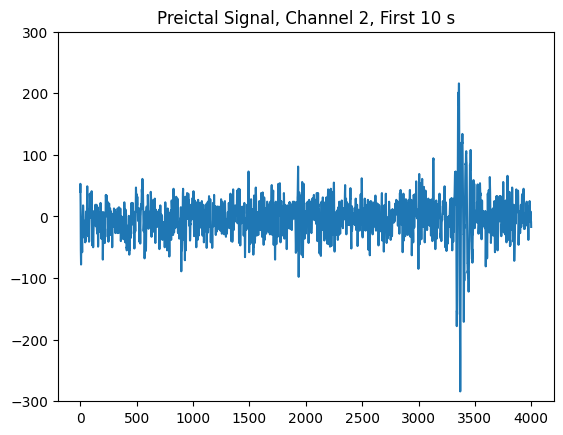

X shape: (59, 4000, 16)


In [6]:
# create tensors
import tensorflow as tf
import torch

WINDOW_SIZE = 4000  # sample count, approximately 10 s
NUM_CHANNELS = 16

extra_rows_interictal = signals_interictal.shape[0] % WINDOW_SIZE
print(signals_interictal.shape[0])
print(extra_rows_interictal)
# exclude last segment if < WINDOW_SIZE
if extra_rows_interictal > 0:
    signals_interictal = signals_interictal[:-extra_rows_interictal, :]
print(signals_interictal.shape)

extra_rows_preictal = signals_preictal.shape[0] % WINDOW_SIZE
# exclude last segment if < WINDOW_SIZE
if extra_rows_preictal > 0:
    signals_preictal = signals_preictal[:-extra_rows_preictal, :]
print(signals_preictal.shape)

max_abs_scaler = MaxAbsScaler()
signals_interictal = max_abs_scaler.fit_transform(signals_interictal)

windowed_interictal = signals_interictal.reshape(-1, WINDOW_SIZE, NUM_CHANNELS)
windowed_preictal = signals_preictal.reshape(-1, WINDOW_SIZE, NUM_CHANNELS)

print(f"Interictal Tensor Shape: {windowed_interictal.shape}")
print(f"Preictal Tensor Shape: {windowed_preictal.shape}")

plt.plot(windowed_interictal[0, :, 1])
plt.title("Interictal Signal, Channel 2, First 10 s")
plt.ylim(-1, 1)
plt.show()
plt.plot(windowed_preictal[0, :, 1])
plt.title("Preictal Signal, Channel 2, First 10 s")
plt.ylim(-300, 300)
plt.show()

# X = np.concatenate( (windowed_interictal, windowed_preictal) )
# y = np.concatenate( (np.zeros(windowed_interictal.shape[0],), np.ones(windowed_preictal.shape[0],)) )
X = windowed_interictal
print(f"X shape: {X.shape}")
# print(f"y shape: {y.shape}")

# Define DCGAN

In [45]:
from tensorflow.keras import layers
import time
from IPython import display

WINDOW_SIZE = 4000  # sample count, approximately 10 s
NUM_CHANNELS = 16
BATCH_SIZE = 16
NOISE_DIM = 100

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# seed for visualizing progress
num_examples_to_generate = 1
seed = tf.random.normal([num_examples_to_generate, NOISE_DIM])


def discriminator_loss(real_output, fake_output):
    """Copied from https://www.tensorflow.org/tutorials/generative/dcgan
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    """Copied from https://www.tensorflow.org/tutorials/generative/dcgan
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def generate_and_save_signals(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(12, 12))

    for i in range(NUM_CHANNELS):
        plt.subplot(4, 4, i+1)
        plt.plot(predictions[0, :, i, 0])
        plt.title(f"Channel {i+1}")

    plt.savefig('./signals_at_epoch_{:04d}.png'.format(epoch))
    plt.show()


class DCGAN():
    def __init__(self):
        self.generator = self.make_generator_model()
        self.discriminator = self.make_discriminator_model()

        self.generator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)
        self.discriminator_optimizer = tf.keras.optimizers.legacy.Adam(1e-4)

        self.checkpoint_dir = './training_checkpoints'
        self.checkpoint_prefix = os.path.join(self.checkpoint_dir, "ckpt")
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.generator_optimizer,
                                         discriminator_optimizer=self.discriminator_optimizer,
                                         generator=self.generator,
                                         discriminator=self.discriminator)

    def make_generator_model(self):
        """Adapted from code here: https://www.tensorflow.org/tutorials/generative/dcgan
        """
        model = tf.keras.Sequential()
        model.add(layers.Dense(int(WINDOW_SIZE/4)*256, use_bias=False, input_shape=(NOISE_DIM,)))
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Reshape((int(WINDOW_SIZE/4), 256)))
        assert model.output_shape == (None, WINDOW_SIZE/4, 256)  # Note: None is the batch size

        model.add(layers.Conv1DTranspose(128, 5, strides=1, padding='same', use_bias=False))
        assert model.output_shape == (None, int(WINDOW_SIZE/4), 128)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv1DTranspose(64, 5, strides=2, padding='same', use_bias=False))
        assert model.output_shape == (None, int(WINDOW_SIZE/2), 64)
        model.add(layers.BatchNormalization())
        model.add(layers.LeakyReLU())

        model.add(layers.Conv1DTranspose(NUM_CHANNELS, 5, strides=2, padding='same', use_bias=False, activation='tanh'))
        model.add(layers.Reshape((WINDOW_SIZE, NUM_CHANNELS, 1)))
        assert model.output_shape == (None, WINDOW_SIZE, NUM_CHANNELS, 1)

        return model

    def make_discriminator_model(self):
        model = tf.keras.Sequential()
        model.add(layers.Conv2D(128, (5, NUM_CHANNELS), strides=(2, 1), padding='valid',
                                         input_shape=[WINDOW_SIZE, NUM_CHANNELS, 1]))
        print(model.output_shape)
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Conv2D(256, (5, 1), strides=(2, 1), padding='valid'))
        print(model.output_shape)
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(0.3))

        model.add(layers.Flatten())
        model.add(layers.Dense(1))

        return model

    # Notice the use of `tf.function`
    # This annotation causes the function to be "compiled".
    @tf.function
    def train_step(self, signals):
        """Mostly copied from https://www.tensorflow.org/tutorials/generative/dcgan
        """
        noise = tf.random.normal([BATCH_SIZE, NOISE_DIM])

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
          generated_signals = self.generator(noise, training=True)

          real_output = self.discriminator(signals, training=True)
          fake_output = self.discriminator(generated_signals, training=True)

          gen_loss = generator_loss(fake_output)
          disc_loss = discriminator_loss(real_output, fake_output)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.discriminator.trainable_variables)

        self.generator_optimizer.apply_gradients(zip(gradients_of_generator, self.generator.trainable_variables))
        self.discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, self.discriminator.trainable_variables))

        results = {'gen_loss': gen_loss, 'disc_loss': disc_loss}
        return results

    def train(self, dataset, epochs):
        """Some code from https://www.tensorflow.org/tutorials/generative/dcgan
        """
        gen_losses = []
        disc_losses = []
        for epoch in range(epochs):
            start = time.time()

            epoch_gen_loss = []
            epoch_disc_loss = []
            for batch in dataset:
                # print("Running training step")
                results = self.train_step(batch)
                epoch_gen_loss.append(results['gen_loss'])
                epoch_disc_loss.append(results['disc_loss'])

            gen_losses.append(np.mean(epoch_gen_loss))
            disc_losses.append(np.mean(epoch_disc_loss))


            # Produce images for the GIF as you go
            display.clear_output(wait=True)
            generate_and_save_signals(self.generator,
                                     epoch + 1,
                                     seed)

            plt.plot(gen_losses, label='Generator Loss')
            plt.plot(disc_losses, label='Discriminator Loss')
            plt.legend()
            plt.show()


            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
              self.checkpoint.save(file_prefix = self.checkpoint_prefix)

            print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

        # Generate after the final epoch
        display.clear_output(wait=True)
        generate_and_save_signals(self.generator,
                               epochs,
                               seed)

        results = {'gen_loss': gen_losses, 'disc_loss': disc_losses}
        return results


dcgan = DCGAN()
noise = tf.random.normal([1, 100])
generated_signal = dcgan.generator(noise, training=False)
print(generated_signal.shape)
decision = dcgan.discriminator(generated_signal)
print(decision)

(None, 1998, 1, 128)
(None, 997, 1, 256)
(1, 4000, 16, 1)
tf.Tensor([[0.00030083]], shape=(1, 1), dtype=float32)


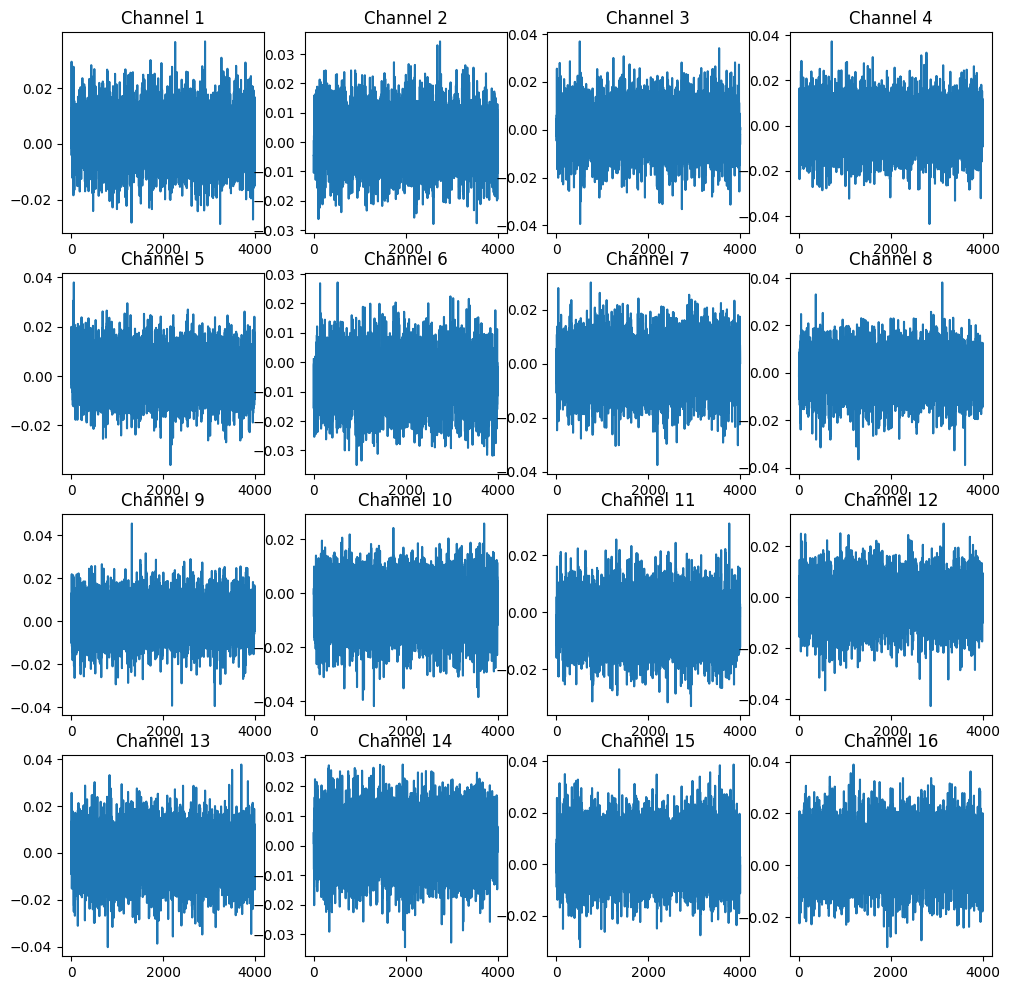

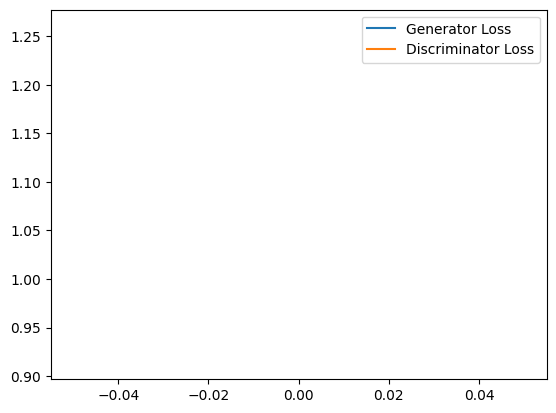

Real Accuracies: [0.0]
Fake Accuracies: [0.0]


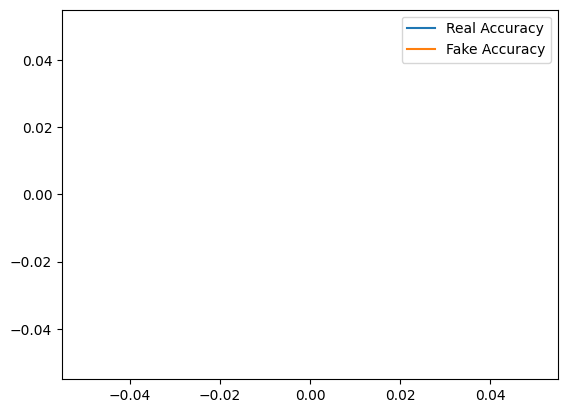

In [46]:
import pickle

EPOCHS = 1
BUFFER_SIZE = 10000

train_dataset = tf.data.Dataset.from_tensor_slices(X).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
results = dcgan.train(train_dataset, EPOCHS)
with open("training_results", 'wb') as f:
    pickle.dump(results, f )

plt.plot(results['gen_loss'], label='Generator Loss')
plt.plot(results['disc_loss'], label='Discriminator Loss')
plt.legend()
plt.show()

In [36]:
with open("training_results", 'wb') as f:
    pickle.dump(results, f )